In [1]:
!pip install metric-learn
#!pip install pygraphviz
#import torch
#import torch.nn as nn
from scipy.spatial import cKDTree
#import torch.nn.functional as F
#import torch_geometric.utils as pyg_utils
#from torch_geometric.utils.convert import to_networkx
#from networkx.drawing.nx_agraph import to_agraph
#import torch.nn.parallel
#import torch_geometric
#import networkx as nx
import pandas as pd
import numpy as np
import pickle
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
#import multiprocessing
#import multiprocessing as mp
from metric_learn import MMC
from sklearn.neighbors import KDTree
#from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
#from concurrent.futures import ThreadPoolExecutor
import time
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 2.4 MB/s eta 0:00:00


In [2]:

# Read the CSV file
df = pd.read_csv('/kaggle/input/10000-recohits-file/RecoOutPileup_uniform_1_10000_16666_ns.root_recohits.csv')

# # Remove rows where muonid is -999
# df = df[df['muonid'] != -999]

# Sort the dataframe by the 't' column in ascending order
df_sorted = df.sort_values(by='t')

# Group by muonid and count occurrences
muonid_counts = df_sorted.groupby('muonid').size().reset_index(name='hit_number')

# Merge the hit_number column into the sorted dataframe
df_with_hit_number = pd.merge(df_sorted, muonid_counts, on='muonid', how='left')

# Write the dataframe to a new CSV file
df_with_hit_number.to_csv('new_file_with_999_time_sorted.csv', index=False)


In [3]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/new-10000-no999-with-hitnumber/new_file_with_hit_number.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=10000)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_dict = {'QPoint': [], 'Neighbours': [], 'MuonID_QP': [], 'Neighbour_MuonIDs': [], 'Delta_Z': [], 'Delta_T': []}
muon_id_column = input_data['muonid']
time_column = input_data['t']
z_column = input_data['z']
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.01)[0]
    neighbor_muon_ids = [muon_id_column[neighbor] for neighbor in neighbors]
    neighbor_delta_z = [abs(z_column[i] - z_column[neighbor]) for neighbor in neighbors]
    neighbor_delta_t = [abs(time_column[i] - time_column[neighbor]) for neighbor in neighbors]
    neighbors_dict['QPoint'].append(i)
    neighbors_dict['Neighbours'].append(neighbors)
    neighbors_dict['MuonID_QP'].append(muon_id_column[i])
    neighbors_dict['Neighbour_MuonIDs'].append(neighbor_muon_ids)
    neighbors_dict['Delta_Z'].append(neighbor_delta_z)
    neighbors_dict['Delta_T'].append(neighbor_delta_t)

# Create DataFrame from the dictionary
df = pd.DataFrame(neighbors_dict)

# Normalize Delta_Z and Delta_T columns
max_delta_z = df['Delta_Z'].apply(lambda x: max(x)).max()
max_delta_t = df['Delta_T'].apply(lambda x: max(x)).max()
df['normalized_delta_z'] = df['Delta_Z'].apply(lambda x: [val / max_delta_z for val in x])
df['normalized_delta_t'] = df['Delta_T'].apply(lambda x: [val / max_delta_t for val in x])

# Drop original Delta_Z and Delta_T columns
df.drop(columns=['Delta_Z', 'Delta_T'], inplace=True)
# Save DataFrame to CSV file
df.to_csv('Edge_ref_test_normalized_10000.csv', index=False)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")



Execution time: 18.519457817077637 seconds


In [ ]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/new-10000-no999-with-hitnumber/new_file_with_hit_number.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=10)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_dict = {'QPoint': [], 'Neighbours': [], 'MuonID_QP': [], 'Neighbour_MuonIDs': [], 'Delta_Z': [], 'Delta_T': []}
muon_id_column = input_data['muonid']
time_column = input_data['t']
z_column = input_data['z']
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.01)[0]
    neighbor_muon_ids = [muon_id_column[neighbor] for neighbor in neighbors]
    neighbor_delta_z = [abs(z_column[i] - z_column[neighbor]) for neighbor in neighbors]
    neighbor_delta_t = [abs(time_column[i] - time_column[neighbor]) for neighbor in neighbors]
    neighbors_dict['QPoint'].append(i)
    neighbors_dict['Neighbours'].append(neighbors)
    neighbors_dict['MuonID_QP'].append(muon_id_column[i])
    neighbors_dict['Neighbour_MuonIDs'].append(neighbor_muon_ids)
    neighbors_dict['Delta_Z'].append(neighbor_delta_z)
    neighbors_dict['Delta_T'].append(neighbor_delta_t)

# Create DataFrame from the dictionary
df = pd.DataFrame(neighbors_dict)

# Normalize Delta_Z and Delta_T columns
max_delta_z = df['Delta_Z'].apply(lambda x: max(x)).max()
max_delta_t = df['Delta_T'].apply(lambda x: max(x)).max()
df['normalized_delta_z'] = df['Delta_Z'].apply(lambda x: [val / max_delta_z for val in x])
df['normalized_delta_t'] = df['Delta_T'].apply(lambda x: [val / max_delta_t for val in x])

# Drop original Delta_Z and Delta_T columns
df.drop(columns=['Delta_Z', 'Delta_T'], inplace=True)

# # Handle missing values using SimpleImputer
# imputer = SimpleImputer(strategy='constant', fill_value=0)  # Fill NaN values with 0
# df[['normalized_delta_z', 'normalized_delta_t']] = imputer.fit_transform(df[['normalized_delta_z', 'normalized_delta_t']])

# # Check for NaN values
# if df.isnull().values.any():
#     print("NaN values still present in the DataFrame.")
# else:
#     print("No NaN values present in the DataFrame.")

# Load the saved Random Forest Classifier model from the pickle file
model_file_path = '/kaggle/input/random-forest/random_forest_model.pkl'
with open(model_file_path, 'rb') as file:
    model = pickle.load(file)

# Function to predict based on delta z and delta t lists
def predict_from_lists(row):
    delta_z_list = row['normalized_delta_z']
    delta_t_list = row['normalized_delta_t']
    predictions = []
    for delta_z, delta_t in zip(delta_z_list, delta_t_list):
        prediction = model.predict([[delta_z, delta_t]])[0]
        predictions.append(prediction)
    return predictions

# Apply prediction function to each row
df['predictions'] = df.apply(predict_from_lists, axis=1)

# Save DataFrame to CSV file
df.to_csv('predictions_on_10000_edg_ref.csv', index=False)
# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

In [2]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/10000-recohits-file/RecoOutPileup_uniform_1_10000_16666_ns.root_recohits.csv')

# Remove rows where 'muonid' column contains -999
df = df[df['muonid'] != -999]

# Save the updated DataFrame to a new CSV file
df.to_csv('old_file_withou_999.csv', index=False)

print("Rows with muonid as -999 removed. Updated file saved as 'updated_file.csv'")


Rows with muonid as -999 removed. Updated file saved as 'updated_file.csv'


In [4]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/including999-time-sorted/new_file_with_999_time_sorted.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=30000)


# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_list = []
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.02848)[0]
    neighbors_list.append(neighbors)

# Extract MuonID1 column
muon_id_column = input_data['muonid']

# Count occurrences of each Muon ID
muon_id_counts = muon_id_column.value_counts()

# Create a list to store data for CSV
csv_data = []

# Initialize a variable to store the previous neighbors
previous_neighbors = set()

# Iterate over each point
for i, neighbors in enumerate(neighbors_list):
    # Check if current QPoint (i) is in the previous_neighbors set
    if i in previous_neighbors:
        continue  # Skip this QPoint if it's already in the previous_neighbors set
    
    # Convert list of neighbors to string with comma separation
    neighbors_str = ', '.join(map(str, neighbors))
    
    # Convert list of neighbor MuonIDs to string with comma separation
    neighbour_muon_ids_str = ', '.join(map(str, [muon_id_column[n] for n in neighbors]))
    
    # Calculate percentage of neighbors with the same MuonID
    total_neighbours = len(neighbors)
    same_muon_id_neighbours = neighbour_muon_ids_str.split(', ').count(str(muon_id_column[i]))
    percentage_same_muon_id = (same_muon_id_neighbours / total_neighbours) * 100
    
    # Get hit number for the current MuonID_QP
    hit_number = muon_id_counts[muon_id_column[i]]
    
    # Calculate percentage of MuonID1 occurrences among neighbors
    if hit_number != 0:
        percentage = (same_muon_id_neighbours / hit_number) * 100
    else:
        percentage = 0
    
    # Create a dictionary for each point
    point_dict = {
        'QPoint': i,
        'MuonID_QP': muon_id_column[i],
        'Hit_Number': hit_number,
        'Neighbours': neighbors_str,  # Convert list to string
        'Neighbour_MuonIDs': neighbour_muon_ids_str,  # Convert list to string
        'Percentage_Same_MuonID': percentage_same_muon_id,
        'Purity': percentage  # Add Percentage column
    }
    csv_data.append(point_dict)
    
    # Update previous_neighbors with the current neighbors
    previous_neighbors.update(neighbors)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(csv_data)

# Save DataFrame to CSV file
df.to_csv('rnngt.csv', index=False)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 4.629866600036621 seconds


In [8]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/including999-time-sorted/new_file_with_999_time_sorted.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=30000)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# Initialize a list to store results
radius_row_counts = []

# Initialize a list to store radius values
radius_values = []

# Loop through the range of radii
for radius in range(5, 501, 5):  # from 0.0005 to 0.05 in steps of 0.0005
    radius_value = radius / 10000.0  # convert to float
    radius_values.append(radius_value)
    
    # KDTree
    tree = KDTree(X_transformed, leaf_size=2)

    # Query neighbors for all points
    neighbors_list = []
    for i in range(len(X_transformed)):
        neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=radius_value)[0]
        neighbors_list.append(neighbors)

    # Extract MuonID1 column
    muon_id_column = input_data['muonid']

    # Count occurrences of each Muon ID
    muon_id_counts = muon_id_column.value_counts()

    # Create a list to store data for CSV
    csv_data = []

    # Initialize a variable to store the previous neighbors
    previous_neighbors = set()

    # Iterate over each point
    for i, neighbors in enumerate(neighbors_list):
        # Check if current QPoint (i) is in the previous_neighbors set
        if i in previous_neighbors:
            continue  # Skip this QPoint if it's already in the previous_neighbors set
        
        # Convert list of neighbors to string with comma separation
        neighbors_str = ', '.join(map(str, neighbors))
        
        # Convert list of neighbor MuonIDs to string with comma separation
        neighbour_muon_ids_str = ', '.join(map(str, [muon_id_column[n] for n in neighbors]))
        
        # Calculate percentage of neighbors with the same MuonID
        total_neighbours = len(neighbors)
        same_muon_id_neighbours = neighbour_muon_ids_str.split(', ').count(str(muon_id_column[i]))
        percentage_same_muon_id = (same_muon_id_neighbours / total_neighbours) * 100
        
        # Get hit number for the current MuonID_QP
        hit_number = muon_id_counts[muon_id_column[i]]
        
        # Calculate percentage of MuonID1 occurrences among neighbors
        if hit_number != 0:
            percentage = (same_muon_id_neighbours / hit_number) * 100
        else:
            percentage = 0
        
        # Create a dictionary for each point
        point_dict = {
            'QPoint': i,
            'MuonID_QP': muon_id_column[i],
            'Hit_Number': hit_number,
            'Neighbours': neighbors_str,  # Convert list to string
            'Neighbour_MuonIDs': neighbour_muon_ids_str,  # Convert list to string
            'Percentage_Same_MuonID': percentage_same_muon_id,
            'Purity': percentage  # Add Percentage column
        }
        csv_data.append(point_dict)
        
        # Update previous_neighbors with the current neighbors
        previous_neighbors.update(neighbors)

    # Create DataFrame from the list of dictionaries
    df = pd.DataFrame(csv_data)
    
    # Append row count to the results list
    radius_row_counts.append(len(df))

# Create DataFrame for radius and row count
df_radius_row_counts = pd.DataFrame({'Radius': radius_values, 'Row_Count': radius_row_counts})

# Save DataFrame to CSV file
df_radius_row_counts.to_csv('radius_row_counts.csv', index=False)

# # Print the results
# print(df_radius_row_counts)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 443.4132442474365 seconds


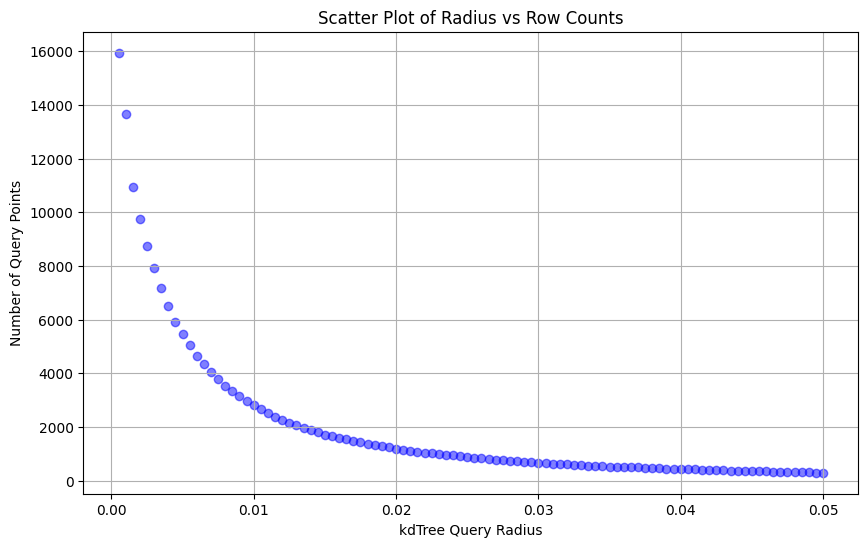

In [2]:
# Read the CSV file containing the radius and row counts
df_radius_row_counts = pd.read_csv('/kaggle/input/radiusrow/radius_row_counts.csv')

# Extract radius and row counts
radius = df_radius_row_counts['Radius']
row_counts = df_radius_row_counts['Row_Count']

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(radius, row_counts, color='blue', alpha=0.5)
plt.title('Scatter Plot of Radius vs Row Counts')
plt.xlabel('kdTree Query Radius')
plt.ylabel('Number of Query Points')
plt.grid(True)

# Save the plot as an image
plt.savefig('RAdius_plot.png')
plt.show()